In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
from pathlib import Path

sys.path.append(Path(os.getcwd()).parent.__str__())

from copy import deepcopy

import hydra
from hydra import compose
from hydra.core.hydra_config import HydraConfig
from omegaconf import OmegaConf, DictConfig
import cv2

from arctic.configs import *

os.environ["PYOPENGL_PLATFORM"] = "egl"

from mesh_fitting.utils.visualization import render_mesh, plot_result
from mesh_fitting.optim.model import CompactATLAS, FullATLAS, FinalATLAS
from mesh_fitting.optim.optim import (
    init_root_pose,
)
import torch
import numpy as np
from typing import List, Dict
import pandas as pd
from tqdm import tqdm
import pickle
import importlib
from mesh_fitting.utils.pipeline import (
    optimize_stages,
    load_cameras,
    load_orig_cameras,
    relax,
    ransac,
    ransac_hand,
    smooth,
    get_min_keypoint_2d_scores,
    get_frame_idxs,
)
from mesh_fitting.optim.model.utils import lod_mapping, lod_proto_mapping
import matplotlib.pyplot as plt

import mesh_fitting

importlib.reload(mesh_fitting)

import mesh_fitting.utils.pipeline
import mesh_fitting.optim.linear

importlib.reload(mesh_fitting.optim.linear)
importlib.reload(mesh_fitting.utils.pipeline)

from mesh_fitting.utils.pipeline import (
    optimize_cameras,
    optimize_stages,
    relax,
    ransac,
    ransac_hand,
    smooth,
    get_min_keypoint_2d_scores,
    get_frame_idxs,
)

from mesh_fitting.optim.utils import distort_fisheye
import roma
import json
from theseus import SO3
from linear_blend_skinning_cuda.quaternions import Quaternion
from mesh_fitting.factors import JointKeypoint3dFactor

In [2]:
sequence = "s01/box_grab_01"

In [3]:
with hydra.initialize(version_base=None, config_path="config"):
    cfg = compose(
        config_name="default.yaml",
        overrides=[
            "+experiment=proto/keypoint_dense/init_single_frame_fitting_pca.yaml",
            "dataset=egohumans",
            f"sequence={sequence}",
            "device='cuda:1'",
        ],
        return_hydra_config=True,
    )
    OmegaConf.resolve(cfg)
    HydraConfig.instance().set_config(cfg)

In [4]:
device = cfg.device
dtype = torch.float64

In [5]:
info_dir = "/large_experiments/3po/data/arctic/arctic/data/arctic_data/data"
split_file = os.path.join(info_dir, "splits", "p1_train.npy")
seq_info = np.load(split_file, allow_pickle=True)[()]
with open(
    "/large_experiments/3po/data/arctic/arctic/data/arctic_data/data/meta/misc.json"
) as f:
    meta_data = json.load(f)

In [6]:
img_dir = os.path.join(info_dir, "images", cfg.sequence)

In [7]:
# Load keypoint info
keypoint_sparse_2d_file = os.path.join(cfg.model.model_data_dir, "keypoints.pkl")
keypoint_sparse_2d_info = pd.read_pickle(keypoint_sparse_2d_file)
keypoint_sparse_2d_joint_mapping = keypoint_sparse_2d_info["joint"]
if "proto" in cfg.model.model_data_dir: 
    keypoint_sparse_2d_dirs = {
        kpt: torch.tensor(kpt_dir, device=device, dtype=dtype)
        for kpt, kpt_dir in keypoint_sparse_2d_info["dirs"].items()
    }
    keypoint_sparse_2d_dirs = {
        kpt: torch.cat(
            [
                dirs[:20][: cfg.model.num_body_shape_comps],
                dirs[20:40][: cfg.model.num_face_shape_comps],
                dirs[40:][: cfg.model.num_hand_shape_comps],
            ]
        )
        for kpt, dirs in keypoint_sparse_2d_dirs.items()
    }
else:
    keypoint_sparse_2d_dirs = {
        kpt: torch.tensor(
            kpt_dir[:16],
            device=device,
            dtype=dtype,
        )
        for kpt, kpt_dir in keypoint_sparse_2d_info["dirs"].items()
    }
keypoint_sparse_2d_mean = {
    kpt: torch.tensor(kpt_mean, device=device, dtype=dtype)
    for kpt, kpt_mean in keypoint_sparse_2d_info["mean"].items()
}
keypoint_sparse_2d_idxs = cfg.keypoints.sparse.keypoint_idxs

keypoint_sparse_2d_info: Dict[str, torch.Tensor] = {
    "idxs": keypoint_sparse_2d_idxs,
    "joint": keypoint_sparse_2d_joint_mapping,
    "dirs": keypoint_sparse_2d_dirs,
    "mean": keypoint_sparse_2d_mean,
}

In [8]:
num_markers = 73
if "proto" in cfg.model.model_data_dir:
    lod_dense_2d = lod_proto_mapping(
        cfg.model.model_data_dir,
        cfg.model.num_body_shape_comps,
        cfg.model.num_face_shape_comps,
        cfg.model.num_hand_shape_comps,
        cfg.model.num_expr_comps,
        lod="lod6",
    )
else:
    lod_dense_2d = lod_mapping(
        cfg.model.model_data_dir,
        cfg.model.num_shape_comps,
        cfg.model.num_expr_comps,
        lod="lod_595",
    )

keypoint_dense_2d_info: Dict[str, torch.Tensor] = {
    "weights": lod_dense_2d["skin_weights"].to(device=device, dtype=dtype),
    "joints": lod_dense_2d["skin_indices"].numpy(),
    "dirs": lod_dense_2d["shape_comps"].to(device=device, dtype=dtype),
    "mean": lod_dense_2d["shape_mean"].to(device=device, dtype=dtype),
}

if "proto" in cfg.model.model_data_dir:
    keypoint_dense_3d_info = pd.read_pickle(
        "/private/home/taoshaf/Documents/projects/arctic/data/proto_markers.pkl"
    )
elif "atlas" in cfg.model.model_data_dir:
    keypoint_dense_3d_info = pd.read_pickle(
        "/private/home/taoshaf/Documents/projects/arctic/data/atlas_markers.pkl"
    )

keypoint_dense_3d_info: Dict[str, torch.Tensor] = {
    "weights": keypoint_dense_3d_info["skin_weights"].to(device=device, dtype=dtype),
    "joints": keypoint_dense_3d_info["skin_indices"].numpy(),
    "dirs": torch.cat(
        [
            keypoint_dense_3d_info["shape_comps"].to(device=device, dtype=dtype),
            torch.zeros(num_markers * 3, num_markers, 3).to(device=device, dtype=dtype),
        ],
        dim=0,
    ),
    "mean": keypoint_dense_3d_info["shape_mean"].to(device=device, dtype=dtype),
}
for marker_idx in range(num_markers):
    keypoint_dense_3d_info["dirs"][
        16 + 3 * marker_idx : 19 + 3 * marker_idx, marker_idx
    ] = 4 * torch.eye(3)

In [9]:
def estimate_root_pose(
    model: FinalATLAS,
    keypoints_3d: torch.Tensor,
    keypoints_3d_ref: torch.Tensor,
):
    b = keypoints_3d.shape[0]
    device = keypoints_3d.device
    dtype = keypoints_3d.dtype
    skel_params = torch.zeros(b, model.num_skel_params).to(device=device, dtype=dtype)
    shape_params = torch.zeros(b, model.num_shape_comps).to(device=device, dtype=dtype)

    _ = model(
        skel_params,
        shape_params,
        do_pcblend=False,
        return_keypoints=False,
        return_joint_coords=False,
        return_joint_params=False,
        return_scales=False,
    )

    joints_t = model.lbs_fn.out_joint_state_t.to(dtype)
    joints_r = model.lbs_fn.out_joint_state_r.to(dtype)

    X = (keypoints_3d_ref - joints_t[..., None, 1, :]) @ joints_r[..., 1, :, :]
    Y = keypoints_3d
    Xmean = X.mean(dim=-2)
    Ymean = Y.mean(dim=-2)
    X = X - Xmean[..., None, :]
    Y = Y - Ymean[..., None, :]
    R = SO3.normalize((Y.transpose(-2, -1) @ X).view(-1, 3, 3))
    rot = joints_r[..., 1, :, :].view(-1, 3, 3).transpose(-2, -1) @ R

    root_pose = skel_params.new_empty(b, 6)
    root_pose[:, 0:3] = (
        Ymean
        - torch.einsum("b...ij,b...j->bi", R, Xmean)
        - model.lbs_fn.joint_offset[1]
    )
    root_pose[:, 3:6] = Quaternion.batchToXYZ(
        Quaternion.batchQuatFromMatrix(rot.to(torch.float32))
    )
    return root_pose.reshape(b, 6).to(dtype)

In [10]:
def load_keypoints(cfg: DictConfig, data_dir: str, cameras: List[str]):
    keypoint_dir: str = os.path.join(data_dir, "keypoints")
    if cfg.keypoint_model is not None:
        keypoint_dir: str = os.path.join(keypoint_dir, cfg.keypoint_model)
    keypoint_data = {}
    for cam in cameras:
        keypoint_cam_dir = os.path.join(keypoint_dir, cam)
        if not os.path.exists(keypoint_cam_dir):
            keypoint_data[cam] = {}
            continue
        image_idxs = sorted(
            [
                int(file[:-4])
                for file in os.listdir(keypoint_cam_dir)
                if file.endswith(".pkl")
            ]
        )
        keypoint_data[cam] = {
            image_idx: pd.read_pickle(
                os.path.join(keypoint_cam_dir, f"{image_idx:06}.pkl")
            )[1]
            for image_idx in image_idxs
        }
    return keypoint_data

In [11]:
model: FinalATLAS = hydra.utils.instantiate(cfg.model).to(device=device, dtype=dtype)
if "proto" in cfg.model.model_data_dir:
    pass
else:
    model.shape_comps[16:] = 0

Loading Proto from /private/home/taoshaf/data/atlas/proto ...
Done loading pkl!
PROTO is using 264 shape components (20 body, 20 face, 5 hand), 43 scale components (18 body, 25 hand), 32 pose PCA components per hand.
Loading Pose Correctives...
Loading LBS function...
Unknown joint name spine_ben in parameter configuration line :
   poseconstraints tpose		spine_bend0=0.0 spine_bend1=0.0 spine_twist0=0.0 spine_twist1=0.0 spine_lean0=0.0 spine_lean1=0.0 neck_bend=0.0 neck_twist=0.0 neck_lean=0.0 l_elbow_bend=-0.5 r_elbow_bend=-0.5 l_knee_bend=0.0 r_knee_bend=0.0 l_foot_lean0=0.0 r_foot_lean0=0.0 l_foot_lean1=0.0 r_foot_lean1=0.0 l_ball_bend=0.0 r_ball_bend=0.0



/private/home/taoshaf/Documents/mesh_fitting/python/mesh_fitting/optim/model/proto.py:201: UserWarning: Sparse CSC tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at /home/conda/feedstock_root/build_artifacts/libtorch_1744247799952/work/aten/src/ATen/SparseCsrTensorImpl.cpp:53.)
  self.lbs_fn.param_transform.to_sparse(layout=torch.sparse_csc),


Loading Hand Prior...


In [12]:
seq: str = cfg.sequence
subject: str = seq.split("/")[0]

seq_dir = os.path.join("/private/home/taoshaf/data/arctic", seq)

offset = meta_data[subject]["ioi_offset"]
cams_int = torch.from_numpy(np.array(meta_data[subject]["intris_mat"])).to(
    device=device, dtype=dtype
)
cams_int = torch.concat(
    [
        cams_int[:, 0, 0][:, None],
        cams_int[:, 1, 1][:, None],
        cams_int[:, 0, 2][:, None],
        cams_int[:, 1, 2][:, None],
    ],
    dim=-1,
)
cams_ext = torch.from_numpy(np.array(meta_data[subject]["world2cam"])).to(
    device=device, dtype=dtype
)[:, :3]
cams_ext[:, :3, 3] *= 100

mocap_path = os.path.join(info_dir, "mocap_npy")
mocap_file = os.path.join(mocap_path, f"{seq.replace('/', '_')}.npy")
mocap_data = np.load(mocap_file, allow_pickle=True)[()]

keypoint_dense_3d_poses = torch.from_numpy(
    mocap_data["subject"]["points"].copy() / 10
).to(device=device, dtype=dtype)
keypoint_dense_3d_scores = torch.ones(
    [keypoint_dense_3d_poses.shape[0], keypoint_dense_3d_poses.shape[1], 1]
).to(device=device, dtype=dtype)

keypoint_dense_3d_poses_cam = (
    torch.einsum("cij,bkj->bcki", cams_ext[:, :3, :3], keypoint_dense_3d_poses)
    + cams_ext[:, None, :, 3]
)

In [13]:
keypoints_l_hand_2d = torch.from_numpy(
    seq_info["data_dict"][seq]["2d"]["joints.left"][:, 1:-1]
).to(device=device, dtype=dtype)
keypoints_r_hand_2d = torch.from_numpy(
    seq_info["data_dict"][seq]["2d"]["joints.right"][:, 1:-1]
).to(device=device, dtype=dtype)

In [14]:
keypoints_l_hand_2d[..., 1, :] = (
    keypoint_dense_3d_poses_cam[:, :, 16, :2]
    / keypoint_dense_3d_poses_cam[:, :, 16, [2]]
) * cams_int[..., :2] + cams_int[..., 2:]

keypoints_r_hand_2d[..., 1, :] = (
    keypoint_dense_3d_poses_cam[:, :, 50, :2]
    / keypoint_dense_3d_poses_cam[:, :, 50, [2]]
) * cams_int[..., :2] + cams_int[..., 2:]

In [15]:
# Load Cameras
num_cams = cams_ext.shape[0]
if cfg.cameras is None:
    cameras: List[str] = [f"{cam_idx}" for cam_idx in range(1, num_cams + 1)]
else:
    cameras: List[str] = cfg.cameras

In [16]:
batch = keypoint_dense_3d_poses.shape[0]
time = 1

cams_ext = cams_ext[None].repeat(batch, 1, 1, 1)
cams_int = cams_int[None].repeat(batch, 1, 1)

In [17]:
frame_idxs = np.arange(batch) + offset
frame_idxs = np.array(frame_idxs)
first_frame_idx = max(6, frame_idxs[0])
last_frame_idx = min(400, frame_idxs[-1])
start = np.where(frame_idxs == first_frame_idx)[0][0]
end = np.where(frame_idxs == last_frame_idx)[0][0]
stride = 1

frame_idxs = frame_idxs[start:end:stride]
cams_ext = cams_ext[start:end:stride]
cams_int = cams_int[start:end:stride]

keypoint_dense_3d_poses = keypoint_dense_3d_poses[start:end:stride]
keypoint_dense_3d_scores = keypoint_dense_3d_scores[start:end:stride]

keypoints_l_hand_2d = keypoints_l_hand_2d[start:end:stride]
keypoints_r_hand_2d = keypoints_r_hand_2d[start:end:stride]

num_frames = len(frame_idxs)

In [18]:
keypoint_sparse_2d_data = load_keypoints(cfg.keypoints.sparse, seq_dir, cameras)
# Load dense 2D keypoint data
try:
    keypoint_dense_2d_data = load_keypoints(cfg.keypoints.dense, seq_dir, cameras)
except:
    keypoint_dense_2d_data = None

if keypoint_dense_2d_data is not None:
    for cam, kpts_dense_cam in keypoint_dense_2d_data.items():
        for frame_idx in kpts_dense_cam:
            if frame_idx not in keypoint_sparse_2d_data[cam]:
                kpts_dense_cam[frame_idx][:, 2] = 0

# Filter and smooth 2D Keypoints
keypoint_sparse_2d_min_scores = torch.tensor(
    get_min_keypoint_2d_scores(cfg.keypoints.sparse), device=device, dtype=dtype
)
keypoint_sparse_2d_data = np.stack(
    [
        [
            keypoint_sparse_2d_data[cam].get(frame_idx, np.zeros([133, 3]))
            for frame_idx in frame_idxs
        ]
        for cam in cameras
    ],
    axis=1,
)
keypoint_sparse_2d_pixels = torch.tensor(
    keypoint_sparse_2d_data[..., :2], device=device, dtype=dtype
)
keypoint_sparse_2d_raw_scores = torch.tensor(
    keypoint_sparse_2d_data[..., 2], device=device, dtype=dtype
)
keypoint_sparse_idxs = cfg.keypoints.sparse.keypoint_idxs
keypoint_sparse_2d_score_flags = 1
keypoint_sparse_2d_scores = relax(
    cfg.filters.relax,
    keypoint_idxs=keypoint_sparse_idxs,
    keypoint_2d_raw_scores=keypoint_sparse_2d_raw_scores
    * keypoint_sparse_2d_score_flags,
    keypoint_2d_min_scores=keypoint_sparse_2d_min_scores,
)

keypoint_sparse_2d_scales = (
    (
        keypoint_sparse_2d_pixels[..., :, :].max(dim=-2, keepdim=True)[0]
        - keypoint_sparse_2d_pixels[..., :, :].min(dim=-2, keepdim=True)[0]
    )
    .expand(*keypoint_sparse_2d_pixels.shape)
    .clone()
).clamp(1)
keypoint_sparse_2d_masks = torch.zeros_like(keypoint_sparse_2d_scores, dtype=bool)
keypoint_sparse_3d_poses = keypoint_sparse_2d_pixels.new_zeros(
    [keypoint_sparse_2d_pixels.shape[0], keypoint_sparse_2d_pixels.shape[-2], 3]
)
keypoint_sparse_3d_masks = keypoint_sparse_2d_pixels.new_zeros(
    [keypoint_sparse_2d_pixels.shape[0], keypoint_sparse_2d_pixels.shape[-2]],
    dtype=bool,
)
keypoint_sparse_3d_scores = keypoint_sparse_3d_masks.to(dtype=dtype)

In [19]:
(
    keypoint_sparse_2d_pixels,
    keypoint_sparse_2d_scores,
    keypoint_sparse_2d_masks,
    keypoint_sparse_3d_poses,
    keypoint_sparse_3d_masks,
) = ransac(
    cfg.filters.ransac,
    keypoint_idxs=keypoint_sparse_idxs,
    keypoint_2d_pixels=keypoint_sparse_2d_pixels,
    keypoint_2d_scores=keypoint_sparse_2d_scores,
    keypoint_2d_scales=keypoint_sparse_2d_scales,
    keypoint_2d_masks=keypoint_sparse_2d_masks,
    keypoint_3d_poses=keypoint_sparse_3d_poses,
    keypoint_3d_masks=keypoint_sparse_3d_masks,
    cams_ext=cams_ext,
    cams_int=cams_int,
)

(
    keypoint_sparse_2d_pixels,
    keypoint_sparse_2d_scores,
    keypoint_sparse_2d_masks,
    keypoint_sparse_3d_poses,
    keypoint_sparse_3d_masks,
) = ransac_hand(
    cfg.filters.ransac_hand,
    keypoint_idxs=keypoint_sparse_idxs,
    keypoint_2d_pixels=keypoint_sparse_2d_pixels,
    keypoint_2d_scores=keypoint_sparse_2d_scores,
    keypoint_2d_scales=keypoint_sparse_2d_scales,
    keypoint_2d_masks=keypoint_sparse_2d_masks,
    keypoint_3d_poses=keypoint_sparse_3d_poses,
    keypoint_3d_masks=keypoint_sparse_3d_masks,
    cams_ext=cams_ext,
    cams_int=cams_int,
)

keypoint_sparse_2d_pixels, keypoint_sparse_3d_poses = smooth(
    cfg.filters.smooth,
    keypoint_idxs=keypoint_sparse_idxs,
    keypoint_2d_pixels=keypoint_sparse_2d_pixels,
    keypoint_2d_scores=keypoint_sparse_2d_scores,
    keypoint_2d_masks=keypoint_sparse_2d_masks,
    keypoint_3d_poses=keypoint_sparse_3d_poses,
    keypoint_3d_masks=keypoint_sparse_3d_masks,
    cams_ext=cams_ext,
    cams_int=cams_int,
)

(
    keypoint_sparse_2d_pixels,
    keypoint_sparse_2d_scores,
    keypoint_sparse_2d_masks,
    keypoint_sparse_3d_poses,
    keypoint_sparse_3d_masks,
) = ransac(
    cfg.filters.ransac,
    keypoint_idxs=keypoint_sparse_idxs,
    keypoint_2d_pixels=keypoint_sparse_2d_pixels,
    keypoint_2d_scores=keypoint_sparse_2d_scores,
    keypoint_2d_scales=keypoint_sparse_2d_scales,
    keypoint_2d_masks=keypoint_sparse_2d_masks,
    keypoint_3d_poses=keypoint_sparse_3d_poses,
    keypoint_3d_masks=keypoint_sparse_3d_masks,
    cams_ext=cams_ext,
    cams_int=cams_int,
)

keypoint_sparse_2d_scores = keypoint_sparse_2d_scores[..., None]
keypoint_sparse_2d_masks = keypoint_sparse_2d_masks[..., None]
keypoint_sparse_3d_scores = keypoint_sparse_3d_scores[..., None]
keypoint_sparse_3d_masks = keypoint_sparse_3d_masks[..., None]

In [20]:
if keypoint_dense_2d_data is not None:
    keypoint_dense_2d_data = np.stack(
        [
            [
                keypoint_dense_2d_data[cam].get(
                    frame_idx, np.zeros([cfg.keypoints.dense.num_keypoints, 3])
                )
                for frame_idx in frame_idxs
            ]
            for cam in cameras
        ],
        axis=1,
    )
else:
    keypoint_dense_2d_data = np.zeros(
        [len(frame_idxs), len(cameras), cfg.keypoints.dense.num_keypoints, 3]
    )
keypoint_dense_2d_pixels = torch.tensor(
    keypoint_dense_2d_data[..., :-1], device=device, dtype=dtype
)

keypoint_dense_2d_scores = (
    np.exp(-keypoint_dense_2d_data[..., -1])
    / np.exp(-keypoint_dense_2d_data[..., -1]).max(axis=-1, keepdims=True)
    * (keypoint_dense_2d_data[..., 2] > 0)
)
keypoint_dense_2d_scores = torch.from_numpy(keypoint_dense_2d_scores).to(
    device=device,
    dtype=dtype,
)
# keypoint_dense_2d_scores *= (
#     keypoint_dense_2d_scores >= 0.95
# )

keypoint_dense_2d_scores = keypoint_dense_2d_scores[..., None]

In [21]:
keypoint_dense_2d_scores *= keypoint_dense_2d_scores >= 0.9

In [22]:
skel_params = torch.zeros(num_frames, model.num_skel_params, device=device, dtype=dtype)
shape_params = torch.zeros(
    num_frames, model.num_shape_comps, device=device, dtype=dtype
)

torso_idxs = [MARKERS.index(marker) for marker in TORSO_MARKERS]
skel_params[..., :6] = estimate_root_pose(
    model,
    keypoint_dense_3d_poses[..., torso_idxs, :],
    keypoint_dense_3d_info["mean"][..., torso_idxs, :],
)

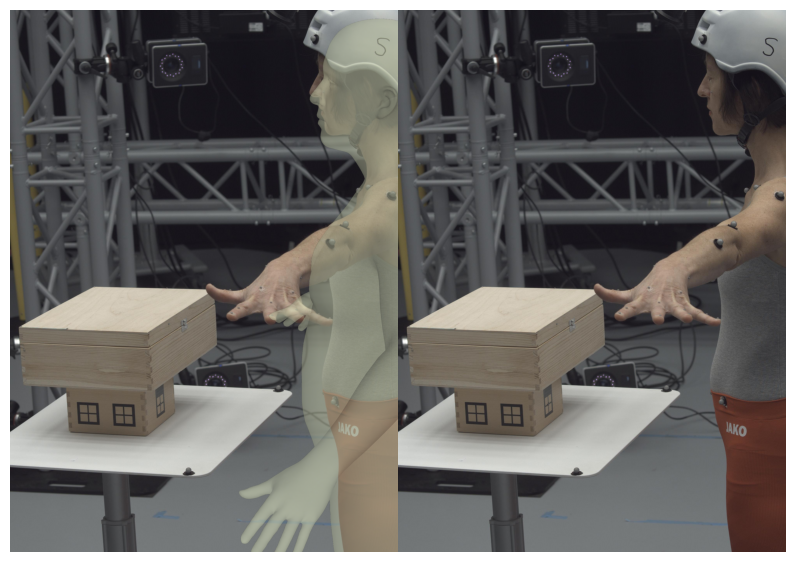

In [23]:
batch_idx = 10
cam_idx = 5
frame_idx = frame_idxs[batch_idx]
cam = cameras[cam_idx]

img_file = os.path.join(img_dir, cam, f"{frame_idx:05}.jpg")
img = cv2.imread(img_file)[:, :, ::-1]

mesh = plot_result(
    model,
    skel_params=skel_params[batch_idx],
    shape_params=shape_params[batch_idx],
    cam_ext=cams_ext[batch_idx, cam_idx],
    cam_int=cams_int[batch_idx, cam_idx],
    image=img,
    bbox=np.array([0, 0, 2000, 2800]),
    # keypoints=keypoint_dense_2d_pixels[batch_idx, cam_idx].cpu().numpy(),
    scale=100,
    alpha=0.5,
)

In [24]:
l_hand_arctic_keypoint_idxs = [
    "left_wrist",
    "left_index_third_joint",
    "left_index_second_joint",
    "left_index_first_joint",
    "left_middle_third_joint",
    "left_middle_second_joint",
    "left_middle_first_joint",
    "left_pinky_third_joint",
    "left_pinky_second_joint",
    "left_pinky_first_joint",
    "left_ring_third_joint",
    "left_ring_second_joint",
    "left_ring_first_joint",
    "left_thumb_third_joint",
    "left_thumb_second_joint",
    "left_thumb_first_joint",
    "left_thumb_tip",
    "left_index_tip",
    "left_middle_tip",
    "left_ring_tip",
    "left_pinky_tip",
]

r_hand_arctic_keypoint_idxs = [
    "right_wrist",
    "right_index_third_joint",
    "right_index_second_joint",
    "right_index_first_joint",
    "right_middle_third_joint",
    "right_middle_second_joint",
    "right_middle_first_joint",
    "right_pinky_third_joint",
    "right_pinky_second_joint",
    "right_pinky_first_joint",
    "right_ring_third_joint",
    "right_ring_second_joint",
    "right_ring_first_joint",
    "right_thumb_third_joint",
    "right_thumb_second_joint",
    "right_thumb_first_joint",
    "right_thumb_tip",
    "right_index_tip",
    "right_middle_tip",
    "right_ring_tip",
    "right_pinky_tip",
]

l_hand_vitpose_keypoint_idxs = [
    cfg.keypoints.sparse.keypoint_idxs[keypoint]
    for keypoint in l_hand_arctic_keypoint_idxs
]

r_hand_vitpose_keypoint_idxs = [
    cfg.keypoints.sparse.keypoint_idxs[keypoint]
    for keypoint in r_hand_arctic_keypoint_idxs
]

keypoint_sparse_2d_pixels[:, :, l_hand_vitpose_keypoint_idxs] = keypoints_l_hand_2d
keypoint_sparse_2d_pixels[:, :, r_hand_vitpose_keypoint_idxs] = keypoints_r_hand_2d
keypoint_sparse_2d_scores[:, :, l_hand_vitpose_keypoint_idxs] = 1
keypoint_sparse_2d_scores[:, :, r_hand_vitpose_keypoint_idxs] = 1

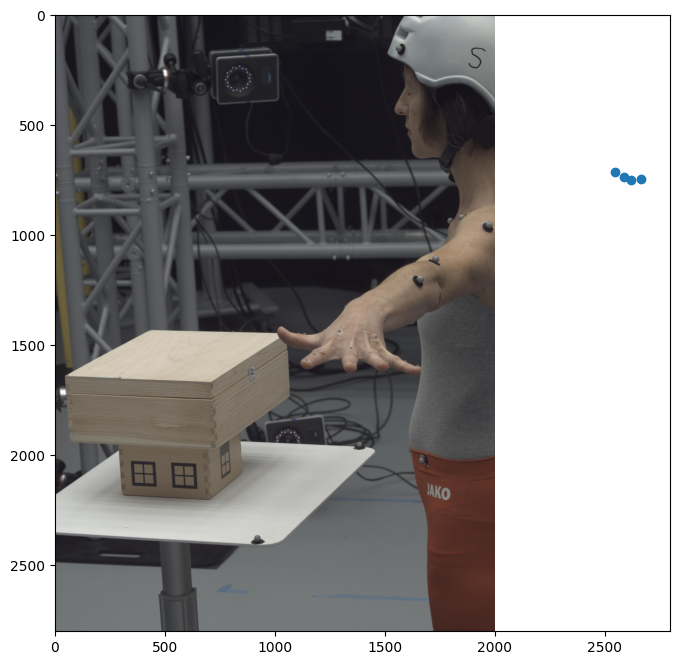

In [25]:
plt.figure(figsize=(8, 8))
plt.imshow(img)
# plt.scatter(
#     keypoint_sparse_2d_pixels[batch_idx, cam_idx, [112], 0].cpu().numpy(),
#     keypoint_sparse_2d_pixels[batch_idx, cam_idx, [112], 1].cpu().numpy(),
# )
plt.scatter(
    keypoint_sparse_2d_pixels[batch_idx, cam_idx, 129:133, 0].cpu().numpy(),
    keypoint_sparse_2d_pixels[batch_idx, cam_idx, 129:133, 1].cpu().numpy(),
)

In [26]:
variables = {
    "cameras_ext": cams_ext,
    "cameras_int": cams_int,
    "skel_params": skel_params,
    "shape_params": shape_params,
}

opt_info = {}
opt_info["keypoint_sparse_2d"] = keypoint_sparse_2d_info
opt_info["keypoint_dense_2d"] = keypoint_dense_2d_info
opt_info["keypoint_dense_3d"] = keypoint_dense_3d_info

opt_data = {}
opt_data["keypoint_dense_3d"] = {
    "keypoint_3d_poses": keypoint_dense_3d_poses,
    "keypoint_3d_scores": keypoint_dense_3d_scores,
}
opt_data["keypoint_dense_2d"] = {
    "keypoint_2d_pixels": keypoint_dense_2d_pixels,
    "keypoint_2d_scores": keypoint_dense_2d_scores,
}
opt_data["keypoint_sparse_2d"] = {
    "keypoint_2d_pixels": keypoint_sparse_2d_pixels,
    "keypoint_2d_scores": keypoint_sparse_2d_scores,
    "keypoint_2d_masks": keypoint_sparse_2d_masks,
    "keypoint_3d_pixels": keypoint_sparse_3d_poses,
    "keypoint_3d_masks": keypoint_sparse_3d_masks,
}

In [27]:
variables, opt_params, opt_states = optimize_stages(
    cfg.optim.init,
    model=model,
    variables=variables,
    opt_params=None,
    opt_states=None,
    opt_info=opt_info,
    opt_data=opt_data,
)

In [28]:
variables_cached = deepcopy(variables)
opt_params_cached = deepcopy(opt_params)
opt_states_cached = deepcopy(opt_states)

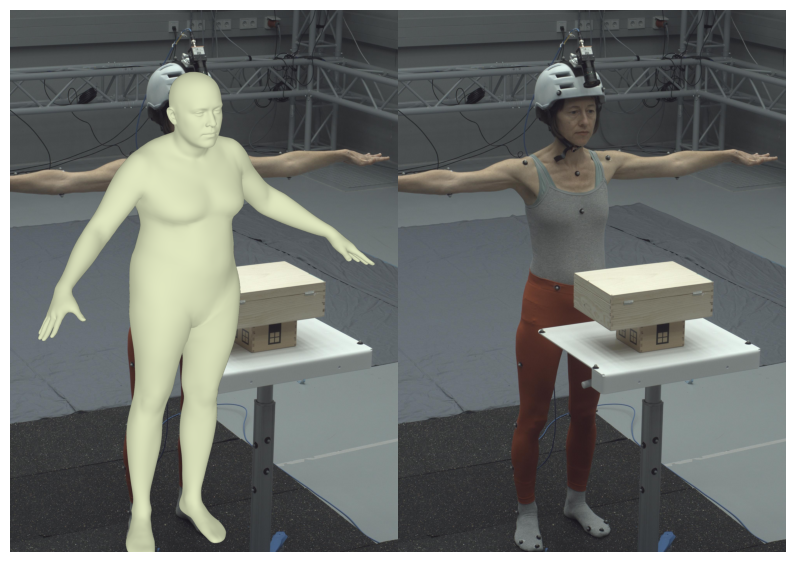

In [29]:
batch_idx = 0
cam_idx = 0
frame_idx = frame_idxs[batch_idx]
cam = cameras[cam_idx]

img_file = os.path.join(img_dir, cam, f"{frame_idx:05}.jpg")
img = cv2.imread(img_file)[:, :, ::-1]

mesh = plot_result(
    model,
    skel_params=variables["skel_params"][batch_idx],
    shape_params=variables["shape_params"][batch_idx],
    cam_ext=variables["cameras_ext"][batch_idx, cam_idx],
    cam_int=variables["cameras_int"][batch_idx, cam_idx],
    image=img,
    bbox=np.array([0, 0, 2000, 2800]),
    scale=100,
)

In [30]:
variables = deepcopy(variables_cached)
opt_params = deepcopy(opt_params_cached)
opt_states = deepcopy(opt_states_cached)
variables, opt_params, opt_states = optimize_stages(
    cfg.optim.pca,
    model=model,
    variables=variables,
    opt_params=opt_params,
    opt_states=opt_states,
    opt_info=opt_info,
    opt_data=opt_data,
)

/private/home/taoshaf/Documents/mesh_fitting/python/mesh_fitting/loss/softplus.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.const = torch.tensor(const)
/private/home/taoshaf/Documents/mesh_fitting/python/mesh_fitting/factors/param_prior_factor.py:104: RuntimeWarning: invalid value encountered in cast
  opt_mapping = (np.nan * np.ones(len(opt_masks), dtype=int)).astype(int)


In [32]:
np.array(opt_states['loss'])[:,90]

array([106712.4125635 , 106553.66177715, 106471.23750319, 106265.36440344,
       106126.26753346])

In [63]:
variables, opt_params, opt_states = optimize_stages(
    cfg.optim.refine,
    model=model,
    variables=variables,
    opt_params=opt_params,
    opt_states=opt_states,
    opt_info=opt_info,
    opt_data=opt_data,
)

In [94]:
np.array(opt_states['loss'])[:, 90]

array([107137.72320428, 106996.06253125, 106901.12582991, 106708.97295121,
       106573.52040528])

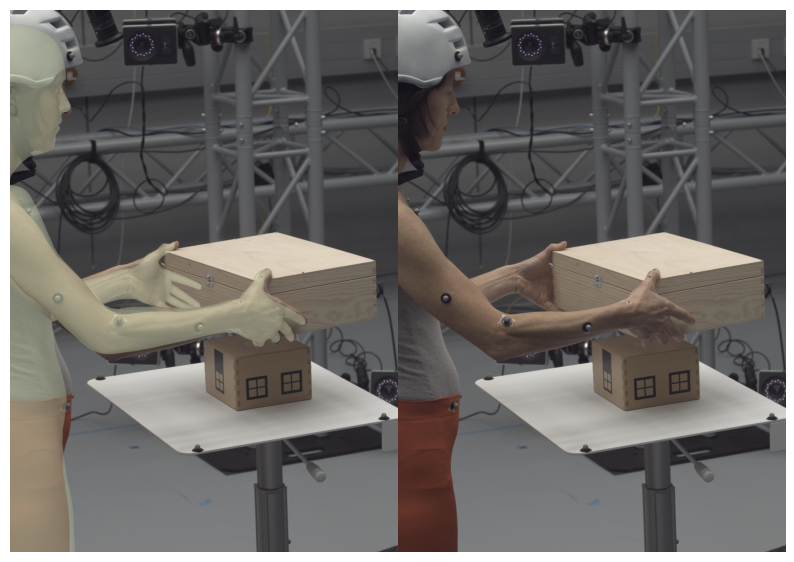

In [64]:
batch_idx = 63 
cam_idx = 2
frame_idx = frame_idxs[batch_idx]
cam = cameras[cam_idx]

img_file = os.path.join(img_dir, cam, f"{frame_idx:05}.jpg")
bbox_file = os.path.join(seq_dir, "bboxes", cam, f"{frame_idx:05}.pkl")

img = cv2.imread(img_file)[:, :, ::-1]
bbox = pd.read_pickle(bbox_file)

outputs = model.forward(
    variables["skel_params"],
    variables["shape_params"],
    return_keypoints=True,
    return_joint_coords=True,
)

cam_ext = variables["cameras_ext"][batch_idx, cam_idx]
cam_int = variables["cameras_int"][batch_idx, cam_idx]
keypoints_3d_cam = (
    outputs["keypoints"][batch_idx] @ cam_ext[:, :3].transpose(-2, -1) + cam_ext[:, 3]
)
keypoints_2d_cam = (keypoints_3d_cam[:, :2] / keypoints_3d_cam[:, [2]]) * cam_int[
    :2
] + cam_int[2:]

mesh = plot_result(
    model,
    skel_params=variables["skel_params"][batch_idx],
    shape_params=variables["shape_params"][batch_idx],
    cam_ext=variables["cameras_ext"][batch_idx, cam_idx],
    cam_int=variables["cameras_int"][batch_idx, cam_idx],
    image=img,
    bbox=bbox,
    scale=100,
    # keypoints=keypoints_2d_cam[list(range(42, 62)) + list(range(21, 41))].cpu().numpy(),
    # keypoints=keypoint_dense_2d_pixels[batch_idx, cam_idx, :].cpu().numpy(),
    alpha=0.5,
)

In [34]:
alpha = 0.0
color = render_mesh(
    outputs["vertices"][batch_idx],
    model.faces,
    cam_ext,
    cam_int,
    img.shape[1],
    img.shape[0],
    100,
)[0]
merged = img * (color[:, :, 3:] == 0) + (
    alpha * (color[:, :, :3] * (color[:, :, 3:] != 0))
    + (1 - alpha) * (img * (color[:, :, 3:] != 0))
)
merged = merged.astype(int)

In [ ]:
plt.figure(figsize=(8, 8))
plt.imshow(merged)
# plt.scatter(
#     keypoint_sparse_2d_pixels[
#         batch_idx, cam_idx, list(range(92, 112)) + list(range(113, 133))
#     ]
#     .cpu()
#     .numpy()[:, 0],
#     keypoint_sparse_2d_pixels[
#         batch_idx, cam_idx, list(range(92, 112)) + list(range(113, 133))
#     ]
#     .cpu()
#     .numpy()[:, 1],
#     s=4,
# )
plt.scatter(
    keypoints_2d_cam[list(range(21, 41)) + list(range(42, 62))].cpu().numpy()[:, 0],
    keypoints_2d_cam[list(range(21, 41)) + list(range(42, 62))].cpu().numpy()[:, 1],
    s=4,
)

In [ ]:
variables["skel_params"][batch_idx, -50:-25]

In [ ]:
variables["skel_params"][batch_idx, -25:]

## Load Results

In [ ]:
from typing import Optional
from mesh_fitting.optim.utils import get_model_outputs


def plot_result(
    model: FinalATLAS,
    skel_params: torch.Tensor,
    shape_params: torch.Tensor,
    cam_ext: torch.Tensor,
    cam_int: torch.Tensor,
    image: np.ndarray,
    bbox: np.ndarray,
    scale: float,
    keypoints: Optional[np.ndarray] = None,
    alpha: float = 1.0,
):
    H, W = image.shape[:2]
    outputs = get_model_outputs(
        model, skel_params[None, None], shape_params[None, None]
    )

    color, mesh = render_mesh(
        vertices=outputs["vertices"][0, 0],
        faces=model.faces,
        extrinsics=cam_ext,
        intrinsics=cam_int,
        width=W,
        height=H,
        scale=scale,
    )

    bbox_xc, bbox_yc = (bbox[:2] + bbox[2:]) // 2
    size = max((0.65 * (bbox[2:] - bbox[:2])).astype(int))
    bbox_cam = [
        max(0, bbox_xc - size),
        max(0, bbox_yc - size),
        min(W, bbox_xc + size),
        min(H, bbox_yc + size),
    ]

    image = image[bbox_cam[1] : bbox_cam[3], bbox_cam[0] : bbox_cam[2]]
    color = color[bbox_cam[1] : bbox_cam[3], bbox_cam[0] : bbox_cam[2]]
    _, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 20))

    merged = image * (color[:, :, 3:] == 0) + (
        (color[:, :, :3] * (color[:, :, 3:] != 0))
    )
    merged = merged.astype(int)
    axes[0].imshow(merged)
    if keypoints is not None:
        axes[0].scatter(
            keypoints[:, 0] - bbox_cam[0], keypoints[:, 1] - bbox_cam[1], s=10
        )
    axes[0].axis("off")

    merged = image * (color[:, :, 3:] == 0) + (
        alpha * (color[:, :, :3] * (color[:, :, 3:] != 0))
        + (1 - alpha) * (image * (color[:, :, 3:] != 0))
    )
    merged = merged.astype(int)
    axes[1].imshow(merged)
    if keypoints is not None:
        axes[0].scatter(
            keypoints[:, 0] - bbox_cam[0], keypoints[:, 1] - bbox_cam[1], s=10
        )
    axes[1].axis("off")

    axes[2].imshow(image)
    if keypoints is not None:
        axes[1].scatter(
            keypoints[:, 0] - bbox_cam[0], keypoints[:, 1] - bbox_cam[1], s=10
        )
    axes[2].axis("off")
    plt.subplots_adjust(wspace=0, hspace=0.02)

    return mesh

In [ ]:
seq = "s01/box_grab_01"
img_dir = os.path.join(info_dir, "images", seq)
seq_dir = os.path.join("/private/home/taoshaf/data/arctic/", seq)
results = pd.read_pickle(
    os.path.join(
        "/private/home/taoshaf/data/arctic/",
        seq,
        "results/proto/dense/init_single_frame_results.pkl",
    )
)["all"]
cams = [f"{cam_idx}" for cam_idx in range(1, 9)]

In [ ]:
mocap_path = os.path.join(info_dir, "mocap_npy")
mocap_file = os.path.join(mocap_path, f"{seq.replace('/', '_')}.npy")
mocap_data = np.load(mocap_file, allow_pickle=True)[()]

keypoint_dense_3d_poses = torch.from_numpy(
    mocap_data["subject"]["points"].copy() / 10
).to(device=device, dtype=dtype)

In [ ]:
subject = seq.split("/")[0]
offset = meta_data[subject]["ioi_offset"]

In [ ]:
keypoints_l_hand_2d = torch.from_numpy(
    seq_info["data_dict"][seq]["2d"]["joints.left"][:, 1:-1]
).to(device=device, dtype=dtype)
keypoints_r_hand_2d = torch.from_numpy(
    seq_info["data_dict"][seq]["2d"]["joints.right"][:, 1:-1]
).to(device=device, dtype=dtype)

In [ ]:
model: FinalATLAS = hydra.utils.instantiate(cfg.model).to(device=device, dtype=dtype)

In [ ]:
frame_idx = 96
cam_idx = 0
result = {
    key: torch.from_numpy(val).to(device, dtype)
    for key, val in results[frame_idx].items()
    if isinstance(val, np.ndarray)
}

cam_ext = result["camera_ext"][cam_idx]
cam_int = result["camera_int"][cam_idx]

cam = cams[cam_idx]
img_file = os.path.join(img_dir, cam, f"{frame_idx:05}.jpg")
bbox_file = os.path.join(seq_dir, "bboxes", cam, f"{frame_idx:05}.pkl")

keypoint = seq

img = cv2.imread(img_file)[:, :, ::-1]
bbox = pd.read_pickle(bbox_file)

keypoints_hand_2d = torch.cat(
    [
        keypoints_r_hand_2d[frame_idx - offset, cam_idx],
        keypoints_l_hand_2d[frame_idx - offset, cam_idx],
    ],
    dim=0,
)

keypoint_3d_poses_cam = (
    keypoint_dense_3d_poses[frame_idx - offset] @ cam_ext[:, :3].transpose(-2, -1)
    + cam_ext[:, 3]
)

keypoints_marker_2d = (
    keypoint_3d_poses_cam[:, :2] / keypoint_3d_poses_cam[:, [2]]
) * cam_int[:2] + cam_int[2:]

outputs = model.forward(
    result["skel_params"][None],
    result["shape_params"][None],
    return_keypoints=True,
    return_joint_coords=True,
)

cam_ext = result["camera_ext"][cam_idx]
cam_int = result["camera_int"][cam_idx]
keypoints_3d_cam = (
    outputs["keypoints"][0] @ cam_ext[:, :3].transpose(-2, -1) + cam_ext[:, 3]
)
keypoints_2d_cam = (keypoints_3d_cam[:, :2] / keypoints_3d_cam[:, [2]]) * cam_int[
    :2
] + cam_int[2:]

# mesh = plot_result(
#     model,
#     skel_params=result["skel_params"],
#     shape_params=result["shape_params"],
#     cam_ext=cam_ext,
#     cam_int=cam_int,
#     image=img,
#     bbox=bbox,
#     scale=100,
#     keypoints=keypoints_hand_2d.cpu().numpy(),
#     alpha=1,
# )

alpha = 1
color = render_mesh(
    outputs["vertices"][0],
    model.faces,
    cam_ext,
    cam_int,
    img.shape[1],
    img.shape[0],
    100,
)[0]
merged = img * (color[:, :, 3:] == 0) + (
    alpha * (color[:, :, :3] * (color[:, :, 3:] != 0))
    + (1 - alpha) * (img * (color[:, :, 3:] != 0))
)
merged = merged.astype(int)

plt.figure(figsize=(8, 8))
plt.imshow(merged)
plt.axis("off")

# plt.scatter(
#     keypoints_marker_2d.cpu().numpy()[[16, 50], 0],
#     keypoints_marker_2d.cpu().numpy()[[16, 50], 1],
# )

# plt.scatter(
#     keypoints_hand_2d.cpu().numpy()[:, 0],
#     keypoints_hand_2d.cpu().numpy()[:, 1],
#     s=5,
# )
# plt.scatter(
#     keypoints_2d_cam[list(range(21, 41)) + list(range(42, 62))].cpu().numpy()[:, 0],
#     keypoints_2d_cam[list(range(21, 41)) + list(range(42, 62))].cpu().numpy()[:, 1],
#     s=5,
# )

In [ ]:
frame_idx = 655
cam_idx = 1
result = {
    key: torch.from_numpy(val).to(device, dtype)
    for key, val in results[frame_idx].items()
    if isinstance(val, np.ndarray)
}

cam_ext = result["camera_ext"][cam_idx]
cam_int = result["camera_int"][cam_idx]

cam = cams[cam_idx]
img_file = os.path.join(img_dir, cam, f"{frame_idx:05}.jpg")
bbox_file = os.path.join(seq_dir, "bboxes", cam, f"{frame_idx:05}.pkl")

keypoint = seq

img = cv2.imread(img_file)[:, :, ::-1]
bbox = pd.read_pickle(bbox_file)

H, W = img.shape[:2]
mesh = plot_result(
    model,
    skel_params=result["skel_params"],
    shape_params=result["shape_params"],
    cam_ext=result["camera_ext"][cam_idx],
    cam_int=result["camera_int"][cam_idx],
    image=img,
    bbox=bbox,
    scale=100,
    alpha=0.5,
)

In [ ]:
alpha = 0.5
color = render_mesh(
    outputs["vertices"][0],
    model.faces,
    cam_ext,
    cam_int,
    img.shape[1],
    img.shape[0],
    100,
)[0]
merged = img * (color[:, :, 3:] == 0) + (
    alpha * (color[:, :, :3] * (color[:, :, 3:] != 0))
    + (1 - alpha) * (img * (color[:, :, 3:] != 0))
)
merged = merged.astype(int)

plt.figure(figsize=(8, 8))
plt.imshow(merged)
plt.axis("off")

# plt.scatter(
#     keypoints_hand_2d.cpu().numpy()[:, 0],
#     keypoints_hand_2d.cpu().numpy()[:, 1],
#     s=4,
# )
# plt.scatter(
#     keypoints_2d_cam[list(range(21, 41)) + list(range(42, 62))].cpu().numpy()[:, 0],
#     keypoints_2d_cam[list(range(21, 41)) + list(range(42, 62))].cpu().numpy()[:, 1],
#     s=4,
# )

In [ ]:
cfg.optim.pca.stages[6].factors["model_state_factors"]["keypoint_sparse_2d"]

In [ ]:
body_joint_factors = hydra.utils.instantiate(
    cfg.optim.pca.stages[6].factors["model_state_factors"]["keypoint_sparse_2d"][
        "body_keypoint_2d"
    ]
)(
    keypoint_dirs=keypoint_sparse_2d_dirs,
    keypoint_mean=keypoint_sparse_2d_mean,
    keypoint_2d_pixels=keypoint_sparse_2d_pixels[:1, None],
    keypoint_2d_confidence=keypoint_sparse_2d_scores[:1, None],
    keypoint_2d_idxs=keypoint_sparse_2d_idxs,
    keypoint_joint_idxs=keypoint_sparse_2d_joint_mapping,
    camera_scales=cams_int[:, None, ..., :2].norm(dim=-1, keepdim=True) / 32,
)[
    "body_joint_keypoint_2d"
]

body_keypoint_factors = hydra.utils.instantiate(
    cfg.optim.pca.stages[6].factors["model_state_factors"]["keypoint_sparse_2d"][
        "body_keypoint_2d"
    ]
)(
    keypoint_dirs=keypoint_sparse_2d_dirs,
    keypoint_mean=keypoint_sparse_2d_mean,
    keypoint_2d_pixels=keypoint_sparse_2d_pixels[:1, None],
    keypoint_2d_confidence=keypoint_sparse_2d_scores[:1, None],
    keypoint_2d_idxs=keypoint_sparse_2d_idxs,
    keypoint_joint_idxs=keypoint_sparse_2d_joint_mapping,
    camera_scales=cams_int[:, None, ..., :2].norm(dim=-1, keepdim=True) / 32,
)[
    "body_reduced_keypoint_2d"
]

In [ ]:
from mesh_fitting.optim.utils import get_all_vars
from torchlie.functional import SE3

In [ ]:
def err_fn(dx):
    skel_params_n = skel_params[0]
    shape_params_n = shape_params[0]
    cams_ext_n = cams_ext[0]
    cams_int_n = cams_int[0]

    all_vars = {
        "skel_params": skel_params_n[None, None],
        "shape_params": shape_params_n[None, None],
        "cameras_ext": cams_ext_n[None, None],
        "cameras_int": cams_int_n[None, None],
    }
    all_vars = get_all_vars(model, **all_vars)

    dT = SE3.exp(dx[..., :6])
    dr = dT[..., :3]
    dt = dT[..., 3]
    ds = dx[..., 6].exp()
    joints_t, joints_r, joints_s = all_vars["joint_states"]
    joints_t = torch.einsum("bij,b...kj->b...ki", ds * dr, joints_t) + dt
    joints_r = dr @ joints_r
    joints_s = ds * joints_s
    all_vars["joint_states"] = (joints_t, joints_r, joints_s)

    return body_joint_factors.evaluate(all_vars)[1][0, 0]


def lin_fn():
    skel_params_n = skel_params[0]
    shape_params_n = shape_params[0]
    cams_ext_n = cams_ext[0]
    cams_int_n = cams_int[0]

    opt_vars = {
        "skel_params": skel_params_n[None, None],
        "shape_params": shape_params_n[None, None],
        "cameras_ext": cams_ext_n[None, None],
    }
    aux_vars = {
        "cameras_int": cams_int_n[None, None],
    }
    all_vars = get_all_vars(model, **opt_vars, **aux_vars)
    opt_vars["joint_states"] = all_vars["joint_states"]
    return body_joint_factors.linearize(opt_vars, aux_vars)[-1]

In [ ]:
dx = torch.zeros([1, 7], device=device, dtype=dtype)
jac_gt = torch.autograd.functional.jacobian(err_fn, dx)[..., 0, :]
jacs = lin_fn()

In [ ]:
(jacs["joint_states"][0, 0] - jac_gt).norm()

In [ ]:
def err_fn(dx):
    skel_params_n = skel_params[0]
    shape_params_n = shape_params[0]
    cams_ext_n = cams_ext[0]
    cams_int_n = cams_int[0]

    all_vars = {
        "skel_params": skel_params_n[None, None],
        "shape_params": shape_params_n[None, None],
        "cameras_ext": cams_ext_n[None, None],
        "cameras_int": cams_int_n[None, None],
    }
    all_vars = get_all_vars(model, **all_vars)

    dT = SE3.exp(dx[..., :6])
    dr = dT[..., :3]
    dt = dT[..., 3]
    ds = dx[..., 6].exp()
    joints_t, joints_r, joints_s = all_vars["joint_states"]
    joints_t = torch.einsum("bij,b...kj->b...ki", ds * dr, joints_t) + dt
    joints_r = dr @ joints_r
    joints_s = ds * joints_s
    all_vars["joint_states"] = (joints_t, joints_r, joints_s)

    return body_keypoint_factors.evaluate(all_vars)[1][0, 0]


def lin_fn():
    skel_params_n = skel_params[0]
    shape_params_n = shape_params[0]
    cams_ext_n = cams_ext[0]
    cams_int_n = cams_int[0]

    opt_vars = {
        "skel_params": skel_params_n[None, None],
        "shape_params": shape_params_n[None, None],
        "cameras_ext": cams_ext_n[None, None],
    }
    aux_vars = {
        "cameras_int": cams_int_n[None, None],
    }
    all_vars = get_all_vars(model, **opt_vars, **aux_vars)
    opt_vars["joint_states"] = all_vars["joint_states"]
    return body_keypoint_factors.linearize(opt_vars, aux_vars)[-1]

In [ ]:
dx = torch.zeros([1, 7], device=device, dtype=dtype)
jac_gt = torch.autograd.functional.jacobian(err_fn, dx)[..., 0, :]
jacs = lin_fn()

In [ ]:
(jacs["joint_states"][0, 0] - jac_gt).norm()

In [ ]:
body_dense_2d_factors = hydra.utils.instantiate(
    cfg.optim.pca.stages[2].factors["model_state_factors"]["keypoint_dense_2d"][
        "full_body_dense_2d"
    ]
)(
    model=model,
    keypoint_dirs=keypoint_dense_2d_info["dirs"],
    keypoint_mean=keypoint_dense_2d_info["mean"],
    keypoint_2d_pixels=keypoint_dense_2d_pixels[10:11, None],
    keypoint_2d_confidence=keypoint_dense_2d_scores[10:11, None],
    joint_indices=keypoint_dense_2d_info["joints"],
    joint_weights=keypoint_dense_2d_info["weights"],
)[
    "body_keypoint_dense_factors_0"
]

In [ ]:
def err_fn(dx):
    skel_params_n = skel_params[0]
    shape_params_n = shape_params[0]
    cams_ext_n = cams_ext[0]
    cams_int_n = cams_int[0]

    all_vars = {
        "skel_params": skel_params_n[None, None],
        "shape_params": shape_params_n[None, None],
        "cameras_ext": cams_ext_n[None, None],
        "cameras_int": cams_int_n[None, None],
    }
    all_vars = get_all_vars(model, **all_vars)

    dT = SE3.exp(dx[..., :6])
    dr = dT[..., :3]
    dt = dT[..., 3]
    ds = dx[..., 6:].exp()
    joints_t, joints_r, joints_s = all_vars["joint_states"]
    joints_t = torch.einsum("tnij,btnj->btni", ds[..., None] * dr, joints_t) + dt
    joints_r = dr @ joints_r
    joints_s = ds * joints_s
    all_vars["joint_states"] = (joints_t, joints_r, joints_s)

    return body_dense_2d_factors.evaluate(all_vars)[1][0, 0]


def lin_fn():
    skel_params_n = skel_params[0]
    shape_params_n = shape_params[0]
    cams_ext_n = cams_ext[0]
    cams_int_n = cams_int[0]

    opt_vars = {
        "skel_params": skel_params_n[None, None],
        "shape_params": shape_params_n[None, None],
        "cameras_ext": cams_ext_n[None, None],
    }
    aux_vars = {
        "cameras_int": cams_int_n[None, None],
    }
    all_vars = get_all_vars(model, **opt_vars, **aux_vars)
    opt_vars["joint_states"] = all_vars["joint_states"]
    return body_dense_2d_factors.linearize(opt_vars, aux_vars)[-1]

In [ ]:
dx = torch.zeros(1, 216, 7, device=device, dtype=dtype)
jac_gt = torch.autograd.functional.jacobian(err_fn, dx)[..., 0, :, :]
jacs = lin_fn()

In [ ]:
(
    jac_gt[np.arange(0, 3176)[:, None], :, body_dense_2d_factors.joint_idxs].transpose(
        1, 2
    )
    - jacs["joint_states"].reshape(3176, 2, 8, 7)
).norm()

In [ ]:
body_dense_3d_factors = hydra.utils.instantiate(
    cfg.optim.pca.stages[2].factors["model_state_factors"]["keypoint_dense_3d"][
        "body_keypoint_3d"
    ]
)(
    model=model,
    keypoint_dirs=keypoint_dense_3d_info["dirs"],
    keypoint_mean=keypoint_dense_3d_info["mean"],
    keypoint_3d_poses=keypoint_dense_3d_poses[10:11, None],
    keypoint_3d_confidence=0.5 * keypoint_dense_3d_scores[10:11, None],
    joint_indices=keypoint_dense_2d_info["joints"],
    joint_weights=keypoint_dense_2d_info["weights"],
)[
    "body_full_keypoint_3d_factors_0"
]

In [ ]:
def err_fn(dx):
    skel_params_n = skel_params[0]
    shape_params_n = shape_params[0]
    cams_ext_n = cams_ext[0]
    cams_int_n = cams_int[0]

    all_vars = {
        "skel_params": skel_params_n[None, None],
        "shape_params": shape_params_n[None, None],
        "cameras_ext": cams_ext_n[None, None],
        "cameras_int": cams_int_n[None, None],
    }
    all_vars = get_all_vars(model, **all_vars)

    dT = SE3.exp(dx[..., :6])
    dr = dT[..., :3]
    dt = dT[..., 3]
    ds = dx[..., 6:].exp()
    joints_t, joints_r, joints_s = all_vars["joint_states"]
    joints_t = torch.einsum("tnij,btnj->btni", ds[..., None] * dr, joints_t) + dt
    joints_r = dr @ joints_r
    joints_s = ds * joints_s
    all_vars["joint_states"] = (joints_t, joints_r, joints_s)

    return body_dense_3d_factors.evaluate(all_vars)[1][0, 0]


def lin_fn():
    skel_params_n = skel_params[0]
    shape_params_n = shape_params[0]
    cams_ext_n = cams_ext[0]
    cams_int_n = cams_int[0]

    opt_vars = {
        "skel_params": skel_params_n[None, None],
        "shape_params": shape_params_n[None, None],
        "cameras_ext": cams_ext_n[None, None],
    }
    aux_vars = {
        "cameras_int": cams_int_n[None, None],
    }
    all_vars = get_all_vars(model, **opt_vars, **aux_vars)
    opt_vars["joint_states"] = all_vars["joint_states"]
    return body_dense_3d_factors.linearize(opt_vars, aux_vars)[-1]

In [ ]:
dx = torch.zeros(1, 216, 7, device=device, dtype=dtype)
jac_gt = torch.autograd.functional.jacobian(err_fn, dx)[..., 0, :, :]
jacs = lin_fn()

In [ ]:
(
    jac_gt[np.arange(0, 53)[:, None], :, body_dense_3d_factors.joint_idxs].transpose(
        1, 2
    )
    - jacs["joint_states"].reshape(53, 3, 8, 7)
).norm()